In [1]:
#setup
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SBSSBSBB'
m='PRCP'

# Reconstruction using top eigen-vectors
For measurement = {{m}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.11.3 	required version>=1.12.0 ******* Update Version ******
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=5.2.2 	required version>=6.0.0 ******* Update Version ******


In [5]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)





## Read Statistics File

In [6]:
data_dir='../../Data/Weather'
#file_index='BBBSBBBB'
file_index='SBSSBSBB'

In [7]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [58]:
#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==m)
df.show(5)
print df.count()

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|   1385.6| 41.2511|-111.9417|       PRCP|US1UTWB0017|    42|[00 7E 00 7E 00 7...|2011.0|SBSSBSBB|
|   1385.6| 41.2511|-111.9417|       PRCP|US1UTWB0017|    16|[00 00 00 00 00 0...|2012.0|SBSSBSBB|
|   1319.2| 41.7267|-112.1482|       PRCP|US1UTBE0008|     3|[00 00 00 00 00 0...|2011.0|SBSSBSBB|
|   1319.2| 41.7267|-112.1482|       PRCP|US1UTBE0008|     0|[00 00 00 00 00 0...|2012.0|SBSSBSBB|
|   1451.5| 42.0358|-111.9617|       PRCP|USC00109698|     0|[00 00 00 00 80 5...|1899.0|SBSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows

2523


### Create a matrix with all of the series

In [59]:
rows=df.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()

T=np.vstack(rows)
shape(T)

(2523, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

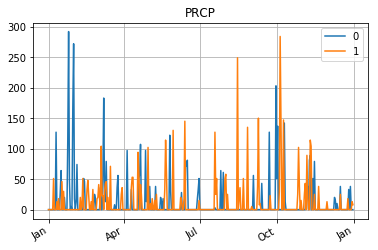

In [60]:
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

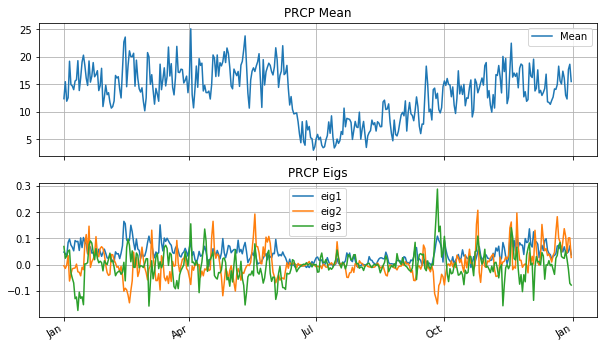

In [61]:
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])#v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])
#print STAT[m]['eigvec']

### plot the percent of residual variance on average

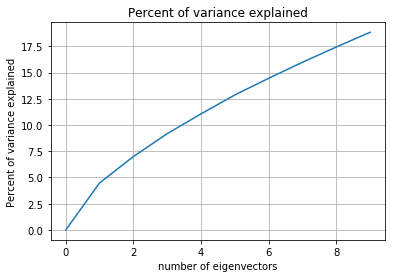

In [62]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

In [32]:
tmp=raw_input();print tmp

fs
fs


In [82]:
i=10
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
eigen_decomp=Eigen_decomp(None,T[i],Mean,v) #reconstruct 10th
total_var,residuals,reductions,coeff=eigen_decomp.compute_var_explained()
res=residuals[1]
print shape(v)
print residuals
print 'residual normalized norm  after mean:',res[0]
print 'residual normalized norm  after mean + top eigs:',res[1:]

(3, 365)
('residual var after mean, eig1,eig2,...', array([ 0.87674038,  0.99482766,  0.9869505 ,  0.97218498]))
residual normalized norm  after mean: 0.876740382758
residual normalized norm  after mean + top eigs: [ 0.99482766  0.9869505   0.97218498]


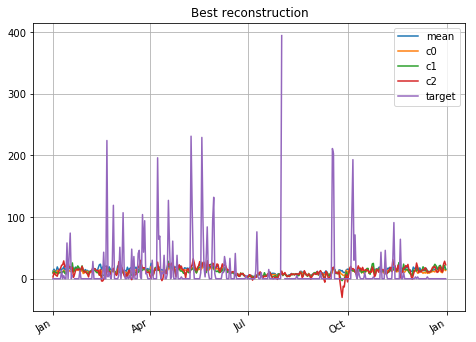

In [84]:
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True)
display(plotter.get_Interactive())

## Process whole dataframe to find best and worse residuals

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.


In [80]:
rows=df.take(10)
L=[]
for row in rows:
    row_out=decompose(row)
    for field in ('res_mean','res_1','res_2','res_3'):
        print field,':',row_out[field],
    print

res_mean : 0.878412885795 res_1 : 1.00005730512 res_2 : 0.994756038348 res_3 : 0.966643616784
res_mean : 0.911995153988 res_1 : 1.00006210567 res_2 : 0.986680347281 res_3 : 0.934150555504
res_mean : 0.876740382758 res_1 : 0.994827658644 res_2 : 0.98695050248 res_3 : 0.972184982186
res_mean : 0.909330826687 res_1 : 0.983109419342 res_2 : 0.970944805319 res_3 : 0.89612324924
res_mean : 0.96684211437 res_1 : 0.975718130612 res_2 : 0.975717440707 res_3 : 0.970789242566
res_mean : 0.904079592919 res_1 : 0.976711545721 res_2 : 0.975900886214 res_3 : 0.958095842609
res_mean : 0.941643454379 res_1 : 0.984826673139 res_2 : 0.962806548356 res_3 : 0.962363236366
res_mean : 0.959068357205 res_1 : 0.954494936211 res_2 : 0.953579648826 res_3 : 0.950185546158
res_mean : 0.892486243171 res_1 : 0.968078352028 res_2 : 0.962457565702 res_3 : 0.962269813975
res_mean : 0.893518831091 res_1 : 0.999380605579 res_2 : 0.980954398698 res_3 : 0.978143780258


In [46]:
def decompose(row):
    """compute residual and coefficients for decomposition           

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :returns: the input row with additional information from the eigen-decomposition.
    :rtype: SparkSQL Row 

    Note that Decompose is designed to run inside a spark "map()" command.
    Mean and v are sent to the workers as local variables of "Decompose"

    """
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)


In [85]:
rdd2=df.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)

#filter out vectors for which the mean is a worse approximation than zero.
print 'before filter',df2.count()
df3=df2.filter(df2.res_mean<1)
df3.show(2)
print 'after filter',df3.count()

before filter 2523
+-------------------+-----------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|          coeff_2|            coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-----------------+-------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-0.7650551588530536|55.68324026249606|-142.39664466587922|   1385.6|SBSSBSBB| 41.2511|-111.9417|       PRCP|1.0000573051216735|0.9947560383477849|0.9666436167842534|0.8784128857947266|US1UTWB0017|1028173.0|    42|[00 7E 00 7E 00 7...|2011.0|
| -3.7681

In [86]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)


In [55]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    """Plot a single reconstruction with an informative title

    :param row: SparkSQL Row that contains the measurements for a particular station, year and measurement. 
    :param Mean: The mean vector of all measurements of a given type
    :param v: eigen-vectors for the distribution of measurements.
    :param fig: a matplotlib figure in which to place the plot
    :param ax: a matplotlib axis in which to place the plot
    :param Title: A plot title over-ride.
    :param interactive: A flag that indicates whether or not this is an interactive plot (widget-driven)
    :returns: a plotter returned by recon_plot initialization
    :rtype: recon_plot

    """
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(range(1,366),target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter

def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
    """plot a grid of reconstruction plots

    :param rows: Data rows (as extracted from the measurements data-frame
    :param column_n: number of columns
    :param row_n:  number of rows
    :param figsize: Size of figure
    :returns: None
    :rtype: 

    """
    fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
    k=0
    for i in range(row_n):
        for j in range(column_n):
            row=rows[k]
            k+=1
            _title='%3.2f,r1=%3.2f,r2=%3.2f,r3=%3.2f'\
                    %(row['res_mean'],row['res_1'],row['res_2'],row['res_3'])
            #print i,j,_title,axes[i,j]
            plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)
    return None


In [87]:
df3=df3.sort(df3.res_3)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+-------------------+
|          res_mean|             res_1|             res_2|              res_3|
+------------------+------------------+------------------+-------------------+
|0.9130698039122399| 0.827909935860254|0.3172346882740371| 0.2555005018724729|
|0.8602629153089433|0.8549621726566826|0.3384174920176717| 0.2869420932692817|
|0.8297332745288889|0.8458201377954135|0.3488912987493451| 0.2907859751019159|
| 0.866581867181739|0.8059959594823468|0.3622059087934591|0.31834698883184676|
+------------------+------------------+------------------+-------------------+
only showing top 4 rows



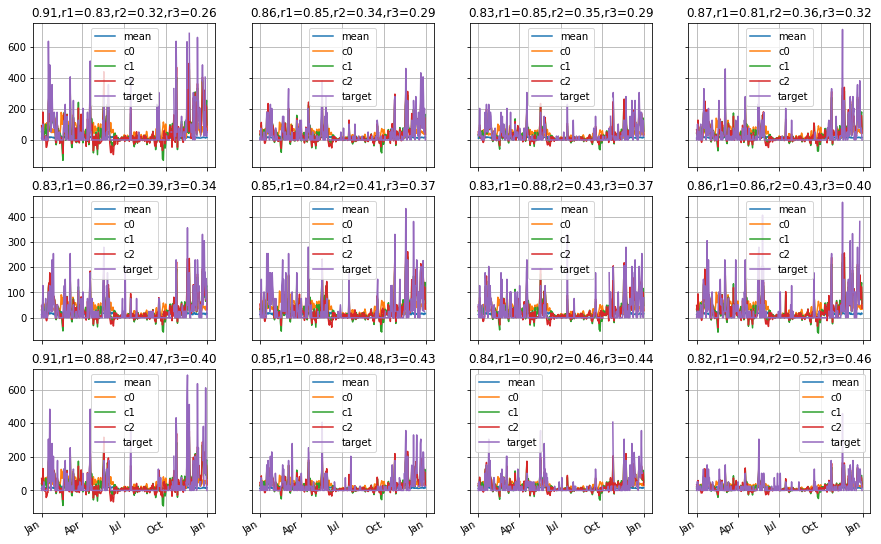

In [88]:
plot_recon_grid(rows)

In [89]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
df3.select('res_mean','res_1','res_2','res_3').show(4)

+------------------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|
+------------------+------------------+------------------+------------------+
|0.8632435127021196|1.0015387501288908|1.0015113411836263|1.0012327167021156|
| 0.917938850064017|0.9999773046951329|0.9997140374313068|0.9996987743472667|
|0.8633267424336781| 0.999945824866419|0.9995983893612326|0.9995944395006499|
|0.9060976021311231|0.9999493955136014|0.9995424032528669|0.9994359156859527|
+------------------+------------------+------------------+------------------+
only showing top 4 rows



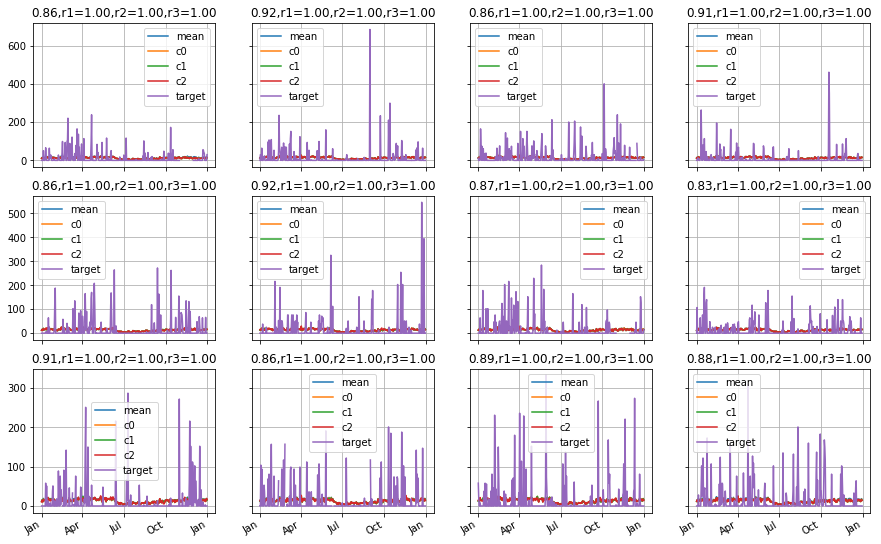

In [90]:
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

[Row(res_3=1.0012327167021156), Row(res_3=0.9996987743472667)]


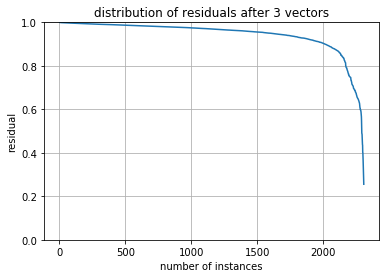

In [92]:
res3=df3.select('res_3').collect()
print res3[:2]
R3=[r['res_3'] for r in res3]
plot(R3)
title('distribution of residuals after 3 vectors')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [93]:
filename=data_dir+'/decon_'+file_index+'_'+m+'.parquet'
!rm -rf $filename
df3.write.parquet(filename)

In [94]:
!du -sh $data_dir/*.parquet

4.6M	../../Data/Weather/US_Weather_BBBSBBBB.parquet
4.6M	../../Data/Weather/US_Weather_SBSSBSBB.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB.parquet
  0B	../../Data/Weather/decon_BBBSBBBB_PRCP.parquet
2.3M	../../Data/Weather/decon_BBBSBBBB_SNWD.parquet
3.1M	../../Data/Weather/decon_BBBSBBBB_TOBS.parquet
3.1M	../../Data/Weather/decon_SBSSBSBB_PRCP.parquet


In [95]:
sc.stop()